This notebook opens JWST files and plots the images as a panel figure.


In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
import sys, os
# !{sys.executable} -m pip install aplpy
import numpy as np
import aplpy
from astropy.table import Table
# !pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar

import warnings
warnings.filterwarnings('ignore')

font = {'weight': 'regular', 
        'size': 16}
font2 = {'weight': 'regular', 
        'size': 12}



In [2]:
#Galaxy specific

GALAXY = "IC5332"
DIST = 8.84 * 10**6 #Wiki
ngcnum = "IC5332"
SN_Sample_File = '../Data/1.FullCatalog-1-4-23.csv'

# grab list of files

# prefix = "/home/maykerchen.1/Desktop/"
# prefix = "/home/mayker.1/Desktop/"
prefix = "/Users/nessmayker/Desktop/"

fileList = prefix + "SNeJWST/Data/filelist" + ngcnum + ".txt"
fileNames = np.genfromtxt(fileList, dtype=str, unpack=True, usecols=(0))
fileNames = [prefix + "JWSTLargeFiles/" + ngcnum + "/" + x for x in fileNames]

data = Table.read(SN_Sample_File, format='csv')

In [3]:
# Functions

# Function to CHECK IF RAS AND DECS ARE IN AN IMAGE
def check_in_image(SNras, SNdecs, SNnames, SNtypes, GalaxyImg):
    
    hdulist = pyfits.open(GalaxyImg)
    map = hdulist[1].data
    wcs = WCS(hdulist[1].header, naxis=0)
    #print(wcs._naxis)
    coords_arr = np.column_stack((SNras, SNdecs)) # ras and decs now [ra,dec]
    pix_x, pix_y = wcs.wcs_world2pix(SNras,SNdecs,0)

    #use world coordinates of all SNe to see if any fall in image (our version of footprint_contains)
    naxis = wcs._naxis #size of image
    naxis1 = hdulist[1].header['NAXIS1']
    naxis2 = hdulist[1].header['NAXIS2']
    is_in_x = (pix_x >= 0) & (pix_x <= naxis1-1) #because of 0-indexing
    is_in_y = (pix_y >= 0) & (pix_y <= naxis2-1)
        
    #get the name, ra, and dec of the SNe that fall in image
    #boolean array indexing (gives back array of Trues and Falses)
    #we are pulling out the SNe that are True and assigning them to own arrays
    name_in_image = np.array(SNnames)[is_in_x & is_in_y]
    type_in_image = np.array(SNtypes)[is_in_x & is_in_y]
    ra_in_image = np.array(SNras)[is_in_x & is_in_y]
    dec_in_image = np.array(SNdecs)[is_in_x & is_in_y]

    x_coord = np.array(pix_x)[is_in_x & is_in_y]
    y_coord = np.array(pix_y)[is_in_x & is_in_y]  
    
    c_delt = hdulist[1].header['CDELT1']
#     dist = 17.69 * 10**6 # Handcoded just for 1566 for now until I know how to find this in file
    theta1kpc = np.arctan((1000./DIST)*(180./np.pi)) # theta for 1kpc scalebar
    theta100pc = np.arctan((100./DIST)*(180./np.pi)) # theta for 1kpc scalebar

    return (name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord, map, naxis1, naxis2, c_delt, dist, theta1kpc, theta100pc)


In [4]:
# set up plots & wcs information.
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.wcs import WCS
plots, wcss, hdus, names, types, ras, decs, xs, ys, maps, nax1s, nax2s, cds, dist = [],[],[],[],[],[],[],[],[],[],[],[],[],[]
scalebars, cutoutsbs =[],[]

for i in range(len(fileNames)):
    if os.path.isfile(fileNames[i]):
        ns, ts, rs, ds, xcs, ycs, ms, n1s, n2s, cd, d, tkpc, tpc = check_in_image(data['RA dds'], data['Dec dds'], data['Name'], data['Type'], fileNames[i])
        names.append(ns)
        types.append(ts)
        ras.append(rs)
        decs.append(ds)
        xs.append(xcs)
        ys.append(ycs)
        maps.append(ms)
        nax1s.append(n1s)
        nax2s.append(n2s)
        cds.append(cd)
        dist.append(d)
        JWST_hdu = pyfits.open(fileNames[i])
        hdus.append(JWST_hdu)
        JWST_map = JWST_hdu[1].data
        plots.append(JWST_map)
        wcss.append(WCS(JWST_hdu[1].header, naxis=2))
        cdelt_as = cd * 3600
        t_as     = tkpc  * 3600
        t_as_cutout = tpc *  3600
        t_as = np.round(t_as,1)
        t_as_cutout =  np.round(t_as_cutout,1)
#         cdelt_pc = d * np.tan(cd*np.pi/180)       
#         sb = ScaleBar(cdelt_pc,"m",dimension="si-length",label="1 kpc",length_fraction=None,fixed_value=1000,
#                       location="lower right",color='white',pad=None, box_alpha=0, font_properties=font, scale_loc = None)
        sb = ScaleBar(cdelt_as,"''",dimension="angle",label="1 kpc",length_fraction=None,fixed_value=t_as,
                      location="lower left",color='black',pad=0.2, box_alpha=0.7, font_properties=font, scale_loc = None)
        scalebars.append(sb)
        sb_co = ScaleBar(cdelt_as,"''",dimension="angle",label="100 pc",length_fraction=None,fixed_value=t_as_cutout,
                      location="lower left",color='black',pad=0.2, box_alpha=0.7, font_properties=font2, scale_loc = None)
        cutoutsbs.append(sb_co)

print(types)

[array([], dtype='<U19'), array([], dtype='<U19'), array([], dtype='<U19'), array([], dtype='<U19')]


In [5]:
# set up legend labels
legendLabels = []

for i in range(len(names)):
    legendlabel = []
        
    if len(names[i]) > 1:
        for k in range(len(names[i])):
            if types[i][k] == 'unclassified' or types[i][k] == 'Unclassified':
                typelabel = names[i][k] + ' '  + types[i][k]
            else:
                typelabel = names[i][k] + ' Type '  + types[i][k]
            legendlabel.append(typelabel)
    elif len(names[i])==0:
        pass
    else:
        if types[i][0] == 'unclassified' or types[i][0] == 'Unclassified':
            legendlabel.append(names[i][0] + ' '  + types[i][0]) 
        else:        
            legendlabel.append(names[i][0] + ' Type '  + types[i][0])
    legendLabels.append(legendlabel)

print(legendLabels)


[[], [], [], []]


In [6]:
# set up plot specifics
from matplotlib.patches import Circle

markerShapes = ["o", "s", "p", "D", "X", "H", "v"]
markerSizes  = [210,150,310,150,330,310,350]
markerEdges  = [410,350,610,350,630,610,650]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

#        1,       2,      3,       4,        5,       6,       7,     8
imgs = ["nircam_clear-f200w", "nircam_clear-f300m", "nircam_clear-f335m",
        "nircam_clear-f360m","miri_f770w", "miri_f1000w", "miri_f1130w", "miri_f2100w"]


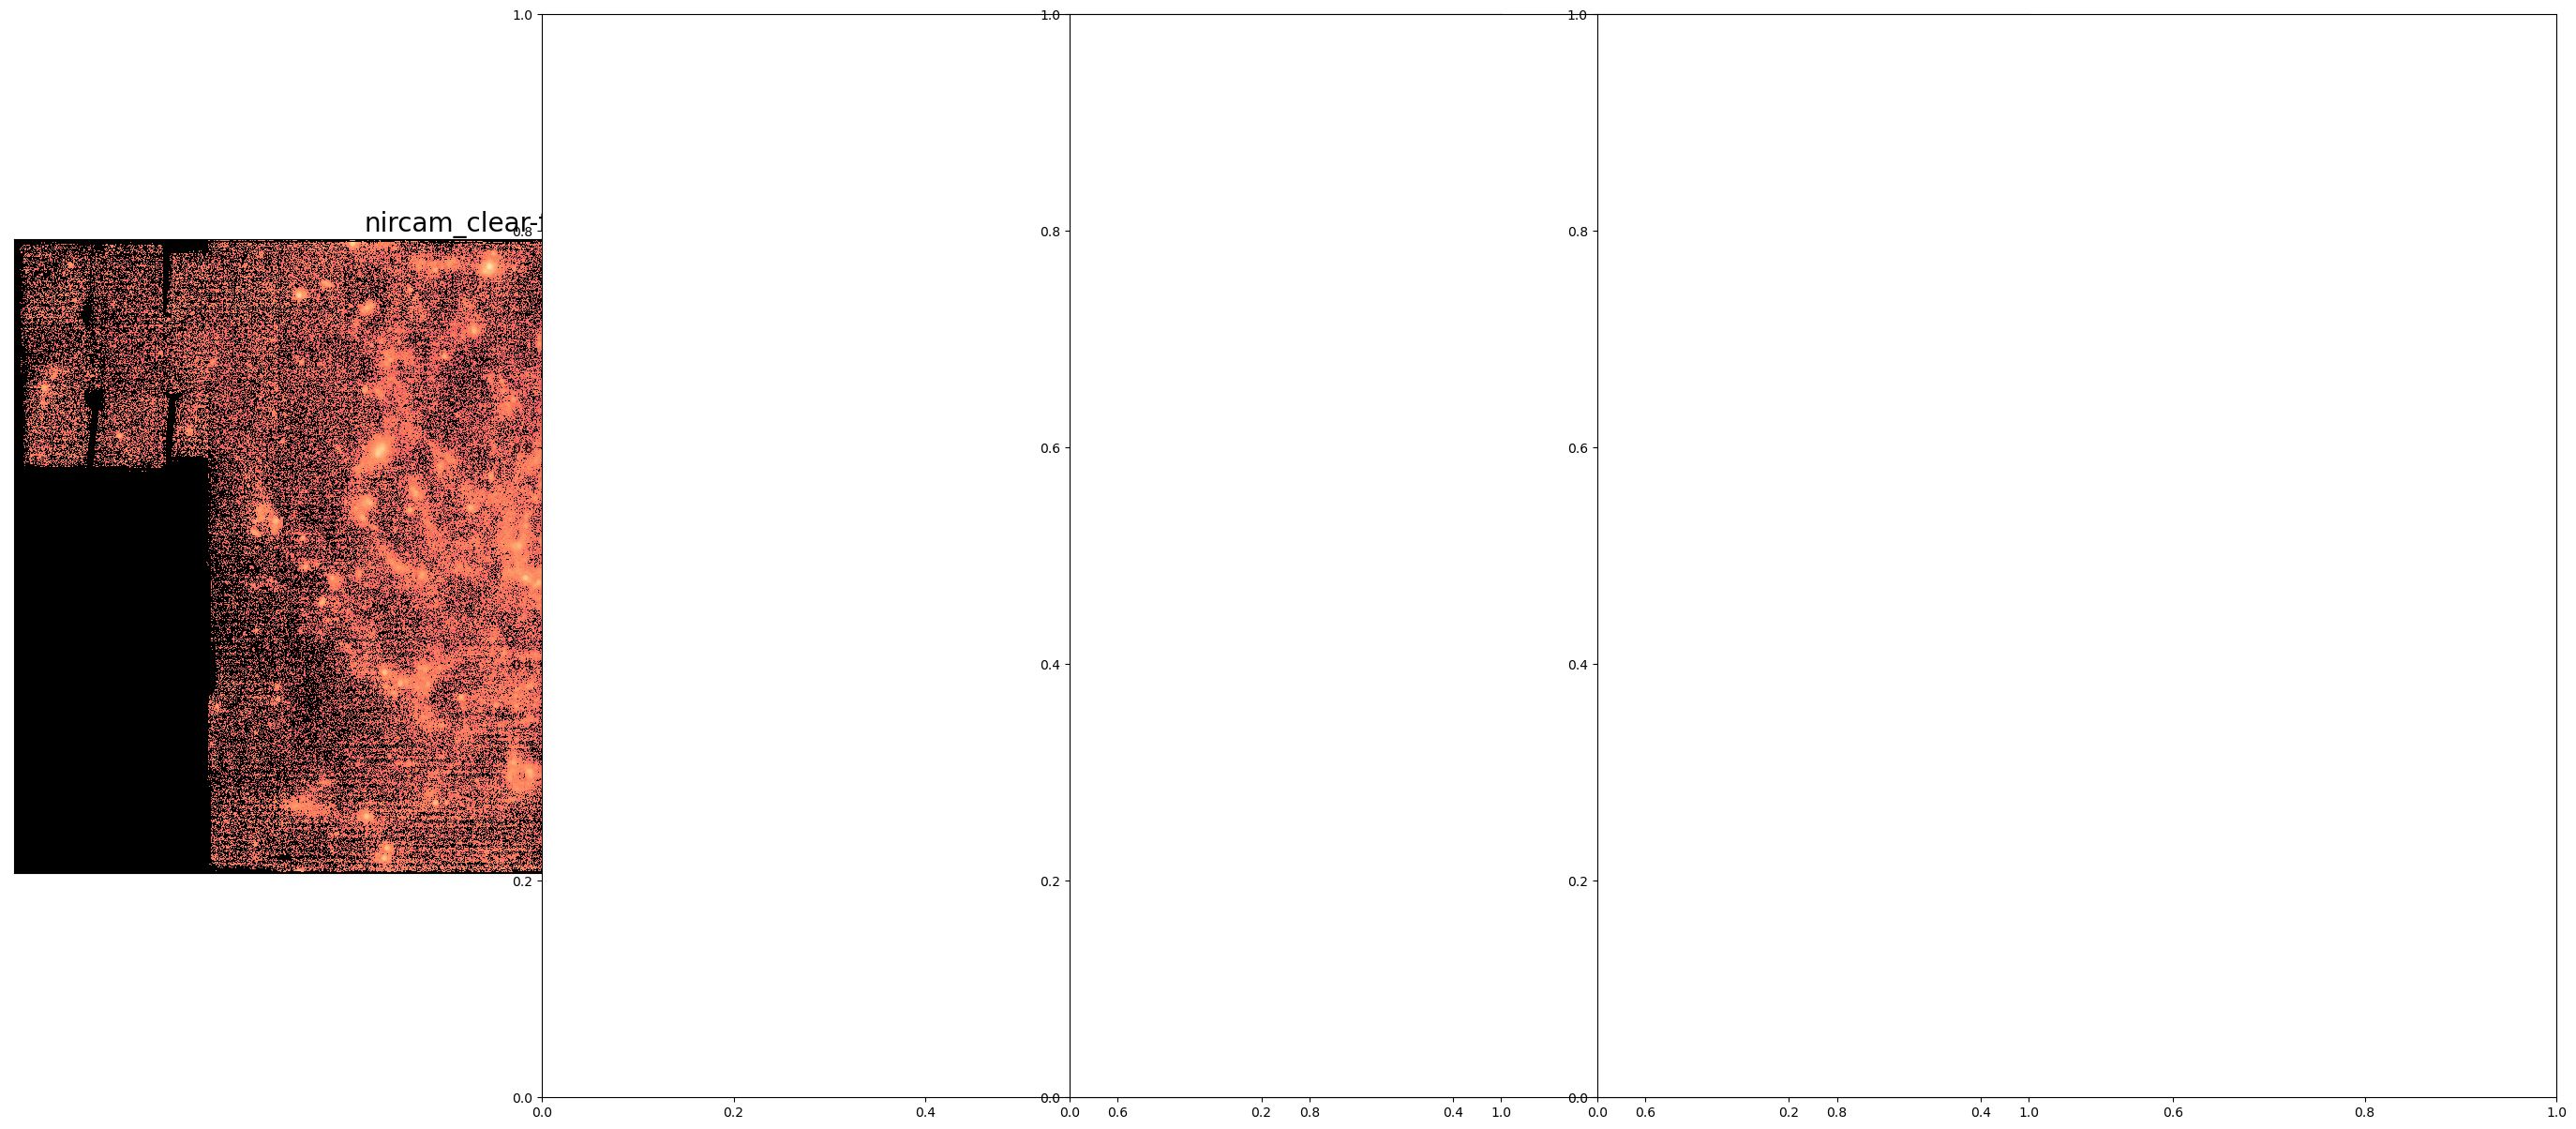

In [7]:
# make multipanel plot  
import math

i,j,m=0,0,0
PLOTS_PER_ROW = 4
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(35, 15))

for plot in plots:
    
    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    
    logplot = np.log10(plot)
    axs[i].imshow(logplot, cmap=current_cmap, aspect="equal", 
                     origin = "lower", interpolation = "nearest")#,
                    #vmin=np.percentile(logplot,1), vmax=np.percentile(logplot,99))
    axs[i].set_title(imgs[m], fontsize=20)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
      
    if len(decs[m]) > 0:
        for n in range(len(decs[m])):
            axs[i].scatter(xArr[n], yArr[n], facecolor = "none", marker = markerShapes[n], s = markerSizes[n], 
                              edgecolor="lime", linewidth=2, label = legendLabels[m][n], zorder = 2)
        axs[i].legend(loc="best", fontsize=14, handletextpad=0.007)
        axs[i].add_artist(scalebars[m])

    m+=1

plt.subplots_adjust(wspace=-0.45, hspace=0.1)
plt.show()
fig.savefig("../Figures/"+GALAXY+"allPanels.png", dpi=300,overwrite=True)
plt.close()


In [8]:
#subplot padding changes

lft = 0.1
btm = 0.1
rht = 0.99
tp  = 0.7
wsp = 0.45
hsp = 0.5
pd  = 0.5
wpd = 3.0
hpd = 0.4

# plotting code
def makeZooms(rows, columns, images, SNra, SNdec, SNname, SNtype, size=(10,5), log=True):
    m,n,p =0,0,0 # plot counters for total number, rows, columns
    PLOTS_PER_ROW = columns
    numPanels = int(rows*columns)
    figname = SNname
    figname, axs = plt.subplots(math.ceil(numPanels/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=size)

    for j in range(len(images)): # counter to count wavelengths

        #set up data to use astropy's cutout2D to plot subsections of galaxy map
        data = plots[j]
        if log == True:
            data = np.log10(data)
        wcs=wcss[j]

        #cutout2D needs skycoord position to carry units
        ra, dec = Angle(SNra * u.degree), Angle(SNdec * u.degree)
        raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
        position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
        hmsdms = position.to_string('hmsdms')
        size = u.Quantity((10,10), u.arcsec) #size is size of box in arcsec 
        # make 2D cutout, will assign a new wcs to cutout to keep track of coords
        cutout = Cutout2D(data, position, size, wcs) 
        # use this new wcs when converting to pixels to add additional details to plot
        xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
        y1 = yval * 0.2
        x1 = xval * 0.1

        titleStr = images[j]

        # make plot
        if rows == 1:
            
            axs[n].set_title(titleStr, fontsize=14)    
            axs[n].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
                          interpolation = "nearest", zorder = 0, vmin=np.percentile(cutout.data,1), vmax=np.percentile(cutout.data,99))
            axs[n].scatter(xval, yval, facecolor = 'none', marker = "o", s = 800, edgecolor="lime",linewidth=2,zorder = 2)
            axs[n].set_xlabel("")
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].tick_params(axis = "both", direction = "in", length = 0)
            axs[n].axis('off')
            axs[n].axhline(y1,0.1,0.2, color="cyan")
            axs[n].text(x1, yval * 0.4, "1 arcsec", color="cyan", horizontalalignment = 'left', verticalalignment = 'top')

            n+=1
            p +=1
            
        else:
            axs[m][n].set_title(titleStr, fontsize=14)    
            axs[m][n].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
                             interpolation = "nearest", zorder = 0, vmin=np.percentile(cutout.data,1), vmax=np.percentile(cutout.data,99))
            axs[m][n].scatter(xval, yval, facecolor = 'none', marker = "o", s = 800, edgecolor="lime",linewidth=2,zorder = 2)
            axs[m][n].set_xlabel("")
            axs[m][n].set_xticks([])
            axs[m][n].set_yticks([])
            axs[m][n].tick_params(axis = "both", direction = "in", length = 0)
            axs[m][n].axis('off')
            axs[m][n].axhline(y1,0.1,0.2, color="cyan")
            axs[m][n].text(x1, yval * 0.4, "1 arcsec", color="cyan", horizontalalignment = 'left', verticalalignment = 'top', fontweight="bold")

            n+=1
            if n%PLOTS_PER_ROW==0:
                m+=1
                n=0
            p +=1
        figname.suptitle(GALAXY + "    " + SNname + ":" + SNtype + "    " + hmsdms, fontsize=18)
        plt.subplots_adjust(left = lft, bottom = btm, right = rht, top = tp, wspace = wsp, hspace = hsp)
    plt.tight_layout(pad=pd, w_pad=wpd, h_pad=hpd)
    figname.savefig("../Figures/"+GALAXY+"_Zooms_" + SNname + ".pdf", dpi=300)
    plt.show()
    plt.close()


In [9]:
# Make zooms for each SN

for i in range(len(names[0])):
    SNname = names[0][i] 
    SNtype = types[0][i] 
    SNra = ras[0][i]
    SNdec = decs[0][i]

    makeZooms(2,4, imgs, SNra, SNdec, SNname, SNtype, log=True)               
